#  Ideal Manipulators

In [1]:
from pref_voting.voting_methods import *
from pref_voting.generate_spatial_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.analysis import *
#from pref_voting.utility_profiles import read_utility_profiles_from_json
import pref_voting
import pandas as pd
from numba import jit
from functools import partial
from multiprocess import Pool, cpu_count, current_process
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
import json
import glob
import os

In [2]:
import pref_voting
print(pref_voting.__version__)

1.13.27


# Setup

## Helper functions

In [6]:
@jit(nopython=True)
def normalized_difference(max_util, 
                          min_util, 
                          exp_u_ws, 
                          new_exp_u_ws):
    return (new_exp_u_ws - exp_u_ws) / (max_util - min_util)

def clone_voter(prof, manip_weight = 1): 

    rankings, rcounts = prof.rankings_counts
    rcounts = list(rcounts)
    rankings = list([tuple(r) for r in rankings])
    new_rcounts = [rcounts[0] + (manip_weight - 1)] + rcounts[1:]
    return Profile(rankings, rcounts=new_rcounts)

def to_linear_prof(uprof): 
    return pref_voting.profiles.Profile([list(map(int, sorted(uprof.domain, key=lambda x: u(x), reverse=True))) for u in uprof.utilities])

def apply_manipulation(prof, new_ranking, manip_weight):
    return pref_voting.profiles.Profile([new_ranking] * manip_weight + prof.rankings[manip_weight:])


In [7]:
def find_normalized_diffs(u, prof, vms):
    
    ws_dict = {vm.name: vm(prof) for vm in vms}
    max_util = np.max([u(c) for c in prof.candidates])
    min_util = np.min([u(c) for c in prof.candidates])
    
    norm_diffs_data = {vm.name:list() for vm in vms}
    for new_r in permutations(prof.candidates): 
        if new_r != prof.rankings[0]:
            new_prof = Profile([new_r] + prof.rankings[1:])
            for vm in vms:
                ws = ws_dict[vm.name]
                new_ws = vm(new_prof)
                if ws != new_ws:                    
                    exp_u_ws  = np.average([u(w) for w in ws])
                    new_exp_u_ws = np.average([u(w) for w in new_ws])
                    norm_diffs_data[vm.name].append(normalized_difference(max_util, min_util, exp_u_ws, new_exp_u_ws))
    pos_data ={vm.name: [d for d in norm_diffs_data[vm.name] if d > 0.0] 
               for vm in vms}
    return {vm.name:  {
        'max': np.max(pos_data[vm.name]) if len(pos_data[vm.name]) > 0 else 0.0, 
        'satisficing': np.mean(pos_data[vm.name]) if len(pos_data[vm.name]) > 0 else 0.0,
        #'random': np.mean(norm_diffs_data[vm.name]) if len(norm_diffs_data[vm.name]) > 0 else 0.0} 
    }
        for vm in vms}

## Generate utility profiles

In [8]:
def gen_util_profile(num_cands, num_voters, num_profiles, probmodel="uniform"):
    """Wrapper function to generate a utility profile given num_cands, num_voters and probability model """

    if probmodel == "uniform":
        return generate_utility_profile_uniform(
            num_cands, num_voters, num_profiles=num_profiles
        )
    elif probmodel == "spatial_2dim":
        num_dims = 2
        sprofs = generate_spatial_profile(num_cands, num_voters, num_dims, num_profiles=num_profiles)
        return [sprof.to_utility_profile() 
                for sprof in sprofs]
    elif probmodel == "spatial_2dim_linear":
        num_dims = 2
        sprofs = generate_spatial_profile(num_cands, num_voters, num_dims, num_profiles=num_profiles)
        return [sprof.to_utility_profile(utility_function = linear_utility) 
                for sprof in sprofs]
    elif probmodel == "spatial_2dim_shepsle":
        num_dims = 2
        sprofs = generate_spatial_profile(num_cands, num_voters, num_dims, num_profiles=num_profiles)
        return [sprof.to_utility_profile(utility_function = shepsle_utility) 
                for sprof in sprofs]
    
prob_models = {
    "uniform": lambda num_candidates, num_voters, num_profiles: gen_util_profile(num_candidates, num_voters, num_profiles, model_type="uniform"),
    "spatial_2dim": lambda num_candidates, num_voters, num_profiles: gen_util_profile(num_candidates, num_voters, num_profiles, model_type="spatial_2dim"),
    "spatial_2dim_linear": lambda num_candidates, num_voters, num_profiles: gen_util_profile(num_candidates, num_voters, num_profiles, model_type="spatial_2dim_linear"),
    "spatial_2dim_shepsle": lambda num_candidates, num_voters, num_profiles: gen_util_profile(num_candidates, num_voters, num_profiles, model_type="spatial_2dim_shepsle"),
}


## Generate samples of normalized differences

In [9]:
def generate_normalized_diff_samples(
        vms, 
        num_cands_list, 
        num_voters_list, 
        probmodel_name, 
        num_samples, 
        num_gen_samples): 

    voting_scenarios = product(num_cands_list,num_voters_list)
    
    prob_model = prob_models[probmodel_name]

    uprofs = [uprof for num_cands, num_voters in voting_scenarios for uprof in prob_model(num_cands, num_voters, num_profiles = num_samples)]

    norm_diff_data = [find_normalized_diffs(uprof.utilities[0], to_linear_prof(uprof), vms) for uprof in uprofs]
    
    return np.array([[d[vm.name]['max'] for d in norm_diff_data] for vm in vms] + [[d[vm.name]['satisficing'] for d in norm_diff_data] for vm in vms] + [[d[vm.name]['random'] for d in norm_diff_data] for vm in vms])

def generate_normalized_diff_samples_fixed_util_profiles(
        vms, 
        all_utility_profs,
        num_samples, 
        step,):

    utility_profiles = all_utility_profs[num_samples*step:num_samples*(step+1)]


    manipulator_utility_fns = [uprof.utilities[0] for uprof in utility_profiles]
    profiles = [to_linear_prof(uprof) for uprof in utility_profiles]

    norm_diff_data = [find_normalized_diffs(u, prof, vms) for u,prof in zip(manipulator_utility_fns, profiles)]
    
    return np.array([[d[vm.name]['max'] for d in norm_diff_data] for vm in vms] + [[d[vm.name]['satisficing'] for d in norm_diff_data] for vm in vms]) # + [[d[vm.name]['random'] for d in norm_diff_data] for vm in vms])

def process_normalized_diff_samples(samples): 
    return samples


# Generate average profitability of ideal manipulators 

In [10]:
# Note that this code will not run unless you have saved the evaluation profiles locally. 

SKIP_SIMULATION = True

os.makedirs("ideal_manipulator_data", exist_ok=True)

if not SKIP_SIMULATION:
    vms_list = [
        plurality, 
        borda,
        instant_runoff, 
        instant_runoff_put, 
        minimax,
        stable_voting, 
        split_cycle, 
        strict_nanson,
        #blacks,
        #copeland_global_borda,
        ]

    num_cands_lists = [
        5, 
        #6,
    ]

    num_voters_lists = [
        5,
        6,
        # 10,
        # 11,
        # 20,
        # 21,
    ]

    decision_rules = [
        'max',
        #'satisficing',
        #'random'
    ]

    data_for_df = {
        'num_cands': list(),
        'num_voters': list(),
        'generation': list(),
        'decision_rule': list(),
        'vm': list(),
        'mean': list(),
        'est_std_error': list(),
        'variance': list(),
        'num_trials': list(),
        'max_std_error': list(),
        'initial_trials': list(),
        'step_trials': list(),
        'min_num_trials': list(),
        'pref_voting_version':list()
    }

    gen = 1
    max_std_error = 0.0005
    initial_trials = 4096
    step_trials = 4096
    min_num_trials = 4095
    max_num_trials = 409600 - 1
    pref_voting_version = pref_voting.__version__

    probmodel = "uniform"

    for num_cands in num_cands_lists:
        print(num_cands)
        for num_voters in num_voters_lists:
            print(num_voters)
            # load the profiles using for evaluation
            # Note that the evaluation profiles are not provided because 
            # of the 50mb limit

            #all_profiles = read_utility_profiles_from_json(f"evaluation_utility_profiles_json/evaluation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.json")
            all_profiles = pickle.load(open(f"evaluation_utility_profiles/evaluation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl", "rb"))

            print("number of profiles: ", len(all_profiles))
            
            gen_samples = partial(generate_normalized_diff_samples_fixed_util_profiles, vms_list, all_profiles)

            means, est_std_errors, variances, num_trials =  means_with_estimated_standard_error(
                gen_samples,
                max_std_error,
                initial_trials=initial_trials, 
                step_trials=step_trials, 
                min_num_trials = min_num_trials, 
                max_num_trials = max_num_trials)
                
            for vm_idx, vm in enumerate(vms_list):
                for decision_rule_idx, decision_rule in enumerate(decision_rules):
                    data_for_df['num_cands'].append(num_cands) 
                    data_for_df['num_voters'].append(num_voters) 
                    data_for_df['generation'].append(gen) 
                    data_for_df['decision_rule'].append(decision_rule) 
                    data_for_df['vm'].append(vm.name) 
                    data_for_df['mean'].append(means[len(vms_list) * decision_rule_idx +  vm_idx]) 
                    data_for_df['est_std_error'].append(est_std_errors[len(vms_list) * decision_rule_idx + vm_idx]) 
                    data_for_df['variance'].append(variances[len(vms_list) * decision_rule_idx + vm_idx]) 
                    data_for_df['num_trials'].append(num_trials)
                    data_for_df['max_std_error'].append(max_std_error)
                    data_for_df['initial_trials'].append(initial_trials)
                    data_for_df['step_trials'].append(step_trials)
                    data_for_df['min_num_trials'].append(min_num_trials)
                    data_for_df['pref_voting_version'].append(pref_voting_version)
            df = pd.DataFrame(data_for_df)
            df.to_csv(f"./ideal_manipulator_data/ideal_voter_{gen}_{probmodel}_{num_cands}_{num_voters}.csv")
    print("done.")
    df

# Visualize results

In [11]:
dfs = list()
for filename in glob.glob("./ideal_manipulator_data/ideal_voter_*.csv"):
    df = pd.read_csv(filename)
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df[combined_df["decision_rule"]=="max"]

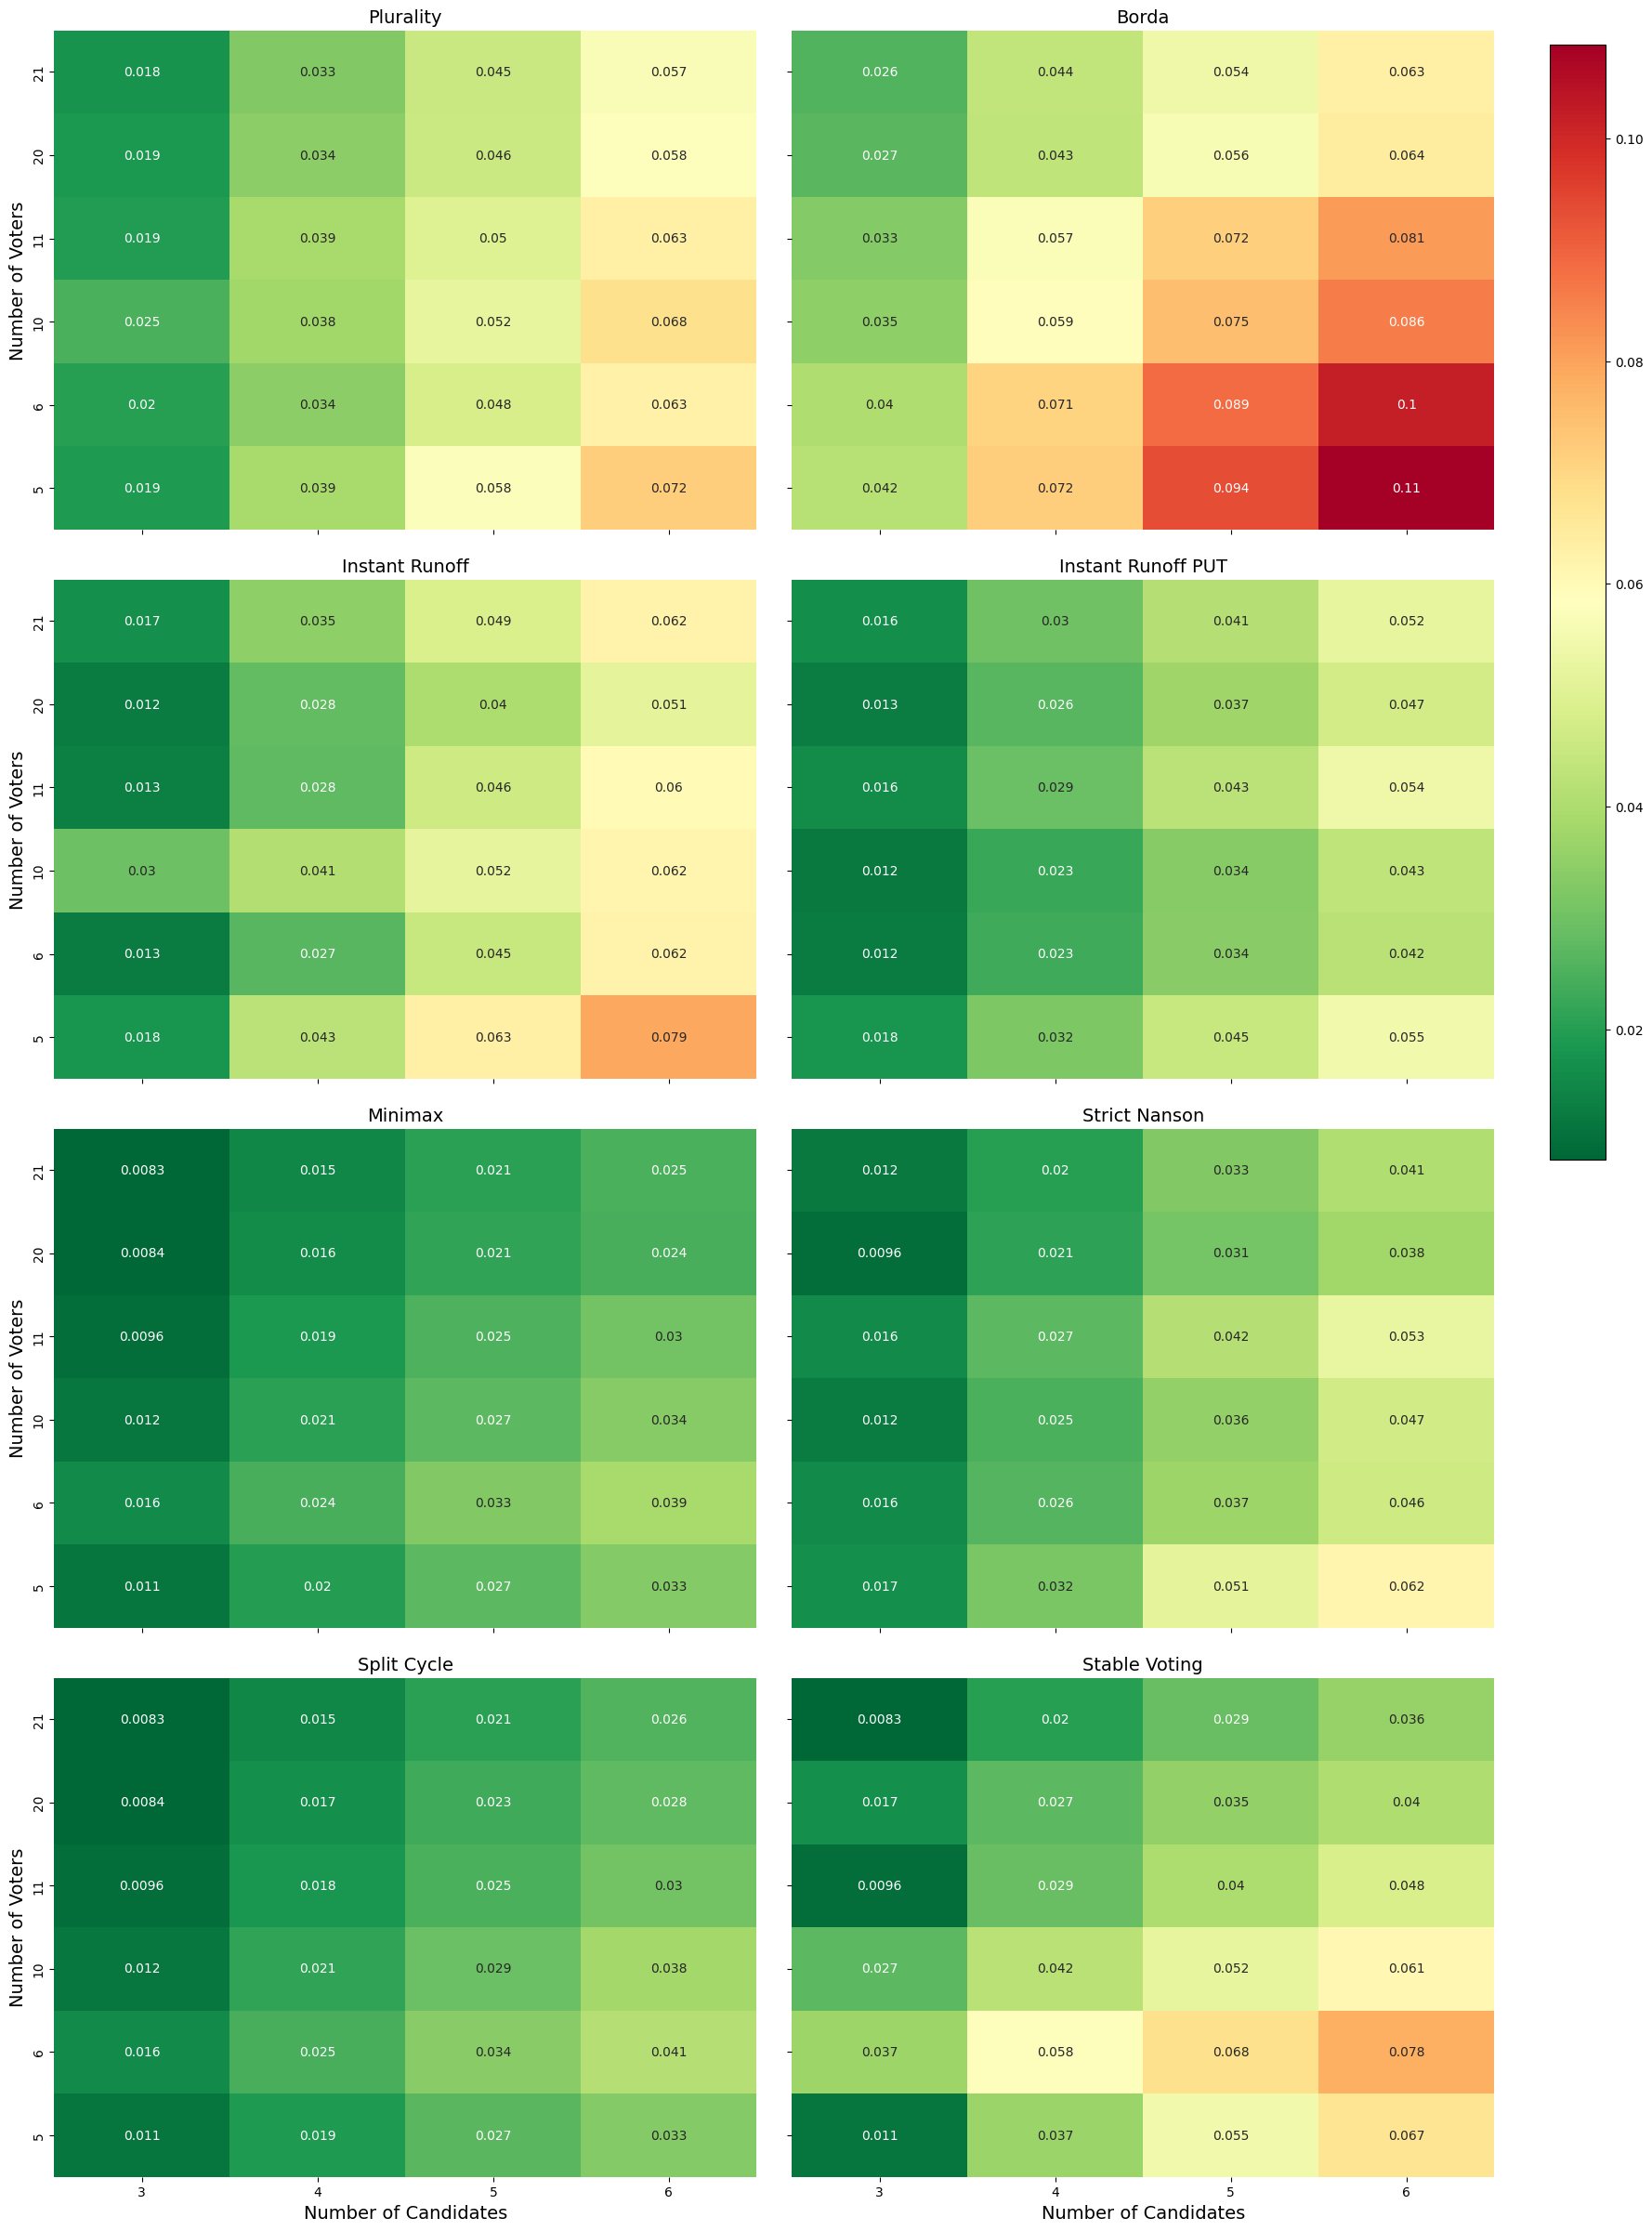

In [12]:

# List of voting methods
voting_methods = [
    "Plurality", 
    "Borda", 
    "Instant Runoff", 
    "Instant Runoff PUT", 
    "Minimax", 
    "Strict Nanson", 
    "Split Cycle", 
    "Stable Voting"]

desc_ordered_num_voters = [21, 20, 11, 10, 6, 5]
# Calculate the minimum and maximum mean values for the color scale
min_mean = combined_df[combined_df['decision_rule'] == 'max']['mean'].min()
max_mean = combined_df[combined_df['decision_rule'] == 'max']['mean'].max()

# Create a figure with shared axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 30), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Generate a heatmap for each voting method
for i, vm in enumerate(voting_methods):
    # Filter and aggregate the data for the specified voting method
    vm_df = combined_df[(combined_df['decision_rule'] == 'max') & (combined_df['vm'] == vm)]
    heatmap_data_vm = vm_df.pivot(index='num_voters', columns='num_cands', values='mean').reindex(desc_ordered_num_voters)

    # Plot heatmap without individual axis labels and with simplified titles
    sns.heatmap(heatmap_data_vm, ax=axes[i], annot=True, cmap='RdYlGn_r', vmin=min_mean, vmax=max_mean, cbar=False)
    # rotate yticks
    axes[i].set_title(vm, fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

axes[0].set_ylabel('Number of Voters', fontsize=14)
axes[2].set_ylabel('Number of Voters', fontsize=14)
axes[4].set_ylabel('Number of Voters', fontsize=14)
axes[6].set_ylabel('Number of Voters', fontsize=14)
axes[6].set_xlabel('Number of Candidates', fontsize=14)
axes[7].set_xlabel('Number of Candidates', fontsize=14)

# Add a single color bar at the end of the figure
cbar_ax = fig.add_axes([0.93, 0.475, 0.03, 0.4])  # Adjusting the position and size of the color bar
fig.colorbar(axes[0].collections[0], cax=cbar_ax)

# Adjust space between heatmaps
plt.subplots_adjust(hspace=0.1, wspace=0.05)

plt.savefig("graphs/ideal_manipulator_data.pdf")
plt.show()
